In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (StandardScaler, OneHotEncoder)
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import (GridSearchCV, cross_val_score)
from sklearn import metrics
import graphviz
from joblib import dump, load
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA

import uilities

In [3]:
# Windows
ROOT = "C:/Users/weiru/OneDrive - University of Leeds/MSc-Lab/datasets"

In [4]:
dataPath = ROOT + "/files/dataset1PTHuse1_400.csv"

In [5]:
df = pd.read_csv(dataPath)

In [6]:
df

,Patient,PTH,Ca,Vit D,Mg,eGFR,Interpretation
0,1,1.1,1.90,72.0,0.1,80,A1
1,2,15.4,2.85,90.0,0.9,66,I
2,3,0.7,1.70,89.0,1.0,90,A2
3,4,2.3,1.90,60.0,0.1,80,B1
4,5,12.2,1.70,32.0,1.0,90,C1
...,...,...,...,...,...,...,...
395,396,15.4,2.85,90.0,0.9,66,I
396,397,0.7,1.70,89.0,1.0,90,A2
397,398,2.3,1.90,60.0,0.1,80,B1
398,399,12.2,1.70,32.0,1.0,90,C1


In [7]:
# Delete Patitent column

df = df.drop(columns=['Patient']).copy()

In [8]:
df

,PTH,Ca,Vit D,Mg,eGFR,Interpretation
0,1.1,1.90,72.0,0.1,80,A1
1,15.4,2.85,90.0,0.9,66,I
2,0.7,1.70,89.0,1.0,90,A2
3,2.3,1.90,60.0,0.1,80,B1
4,12.2,1.70,32.0,1.0,90,C1
...,...,...,...,...,...,...
395,15.4,2.85,90.0,0.9,66,I
396,0.7,1.70,89.0,1.0,90,A2
397,2.3,1.90,60.0,0.1,80,B1
398,12.2,1.70,32.0,1.0,90,C1


In [9]:
class RandomForest():
    
    def __init__(self):
        pass
        
    def removeNull(self, df):
        nonNull_df = df.copy()
        nonNull_df = nonNull_df.dropna(how='any',axis=0)
        return nonNull_df 
    
    def imputedDF(self, df, strategy):
        
        fill_NaN           = SimpleImputer(strategy=strategy)
        df_attr            = df.iloc[:,:-1]

        imputed_DF         = pd.DataFrame(fill_NaN.fit_transform(df_attr))
        imputed_DF.columns = df_attr.columns
        imputed_DF.index   = df_attr.index

        new_df             = imputed_DF.join(df.iloc[:,-1])

        return new_df
    
    
    
    def normalizedDF(self, df):
        normalized            = MinMaxScaler()
        df_attr               = df.iloc[:,:-1]
        normalized_DF         = pd.DataFrame(normalized.fit_transform(df_attr))
        normalized_DF.columns = df_attr.columns
        normalized_DF.index   = df_attr.index
        new_df                = normalized_DF.join(df.iloc[:,-1])
        return new_df
    
    
    
    def standardDF(self, df):
        std_scale      = StandardScaler()
        df_attr        = df.iloc[:,:-1]
        std_DF         = pd.DataFrame(std_scale.fit_transform(df_attr))
        std_DF.columns = df_attr.columns
        std_DF.index   = df_attr.index
        new_df         = std_DF.join(df.iloc[:,-1])
        return new_df
    
    
    
    def checkIsNull(self, df):
        '''
            Check whether the dataframe has nulls
        '''
        if df.isnull().values.any():
            print("Data have nulls")
        else:
            print("Data don't have nulls")
        
        
        
    def pipe(self, CA=""):
        
        RANDOM_STATE = 42
        rfc          = RandomForestClassifier(random_state=RANDOM_STATE)
        pca          = PCA(random_state=RANDOM_STATE)
        lda          = LinearDiscriminantAnalysis()
        
        rfc_pipe     = Pipeline([('rfc', rfc)])
        pca_pipe     = Pipeline([('pca', pca), ('rfc', rfc)])
        lda_pipe     = Pipeline([('lda', lda), ('rfc', rfc)])
        
        if CA == 'pca':
            return pca_pipe
        if CA == 'lda':
            return lda_pipe
        
        return rfc_pipe
    
    
    
    def trainAndTarg(self, df):
    
        attri  = df.iloc[:,:-1]
        target = df.iloc[:, -1]

        return attri,target
    
    
    
    def print_best_param(self, clf_fit):
        print('Best score : ', clf_fit.best_score_)
        print('Best parameters', clf_fit.best_params_)
        
        
        
    def search__best_param(self, df, pipe, criterion, p=False):
        grid_params = {
            'rfc__criterion'            : [criterion], # 'gini', 'entropy'
            'rfc__max_depth'            : [a for a in range(1,20)],
            'rfc__min_samples_split'    : [b for b in range(2,20)],
            'rfc__min_samples_leaf'     : [1],

        }

        clf = GridSearchCV(
            pipe,
            grid_params,
            cv=8,
            n_jobs=-1
        )
        
        attri, target = self.trainAndTarg(df)
        clf_fit = clf.fit(attri, target)

        # print parameter
        if p is True:
            self.print_best_param(clf_fit)

        return clf_fit

In [10]:
Rforest = RandomForest()

### Baseline Experiment

#### remove nulls

In [11]:
def runExp1(df,CA):
    nonNull_df    = Rforest.removeNull(df)
    pipe          = Rforest.pipe(CA)
    criterion     = ['gini', 'entropy']
    clfs          = []
    for c in criterion:
        clfs.append(Rforest.search__best_param(df=nonNull_df, pipe=pipe, criterion=c, p=True))

    return clfs

In [12]:
result_n_n = runExp1(df,'')

Best score :  0.9810938945420906
Best parameters {'rfc__criterion': 'gini', 'rfc__max_depth': 9, 'rfc__min_samples_leaf': 1, 'rfc__min_samples_split': 3}
Best score :  0.9731151711378354
Best parameters {'rfc__criterion': 'entropy', 'rfc__max_depth': 7, 'rfc__min_samples_leaf': 1, 'rfc__min_samples_split': 3}


In [13]:
result_pca_n = runExp1(df,'pca')

Best score :  0.8736123959296946
Best parameters {'rfc__criterion': 'gini', 'rfc__max_depth': 11, 'rfc__min_samples_leaf': 1, 'rfc__min_samples_split': 6}
Best score :  0.8788159111933395
Best parameters {'rfc__criterion': 'entropy', 'rfc__max_depth': 9, 'rfc__min_samples_leaf': 1, 'rfc__min_samples_split': 7}


In [14]:
result_lda_n = runExp1(df,'lda')

Best score :  0.9163390379278447
Best parameters {'rfc__criterion': 'gini', 'rfc__max_depth': 13, 'rfc__min_samples_leaf': 1, 'rfc__min_samples_split': 6}
Best score :  0.9082446808510638
Best parameters {'rfc__criterion': 'entropy', 'rfc__max_depth': 11, 'rfc__min_samples_leaf': 1, 'rfc__min_samples_split': 2}


#### remove nulls + norm

In [15]:
def runExp1_2(df,CA):
    nonNull_df    = Rforest.removeNull(df)
    norm_df       = Rforest.normalizedDF(nonNull_df)
    pipe          = Rforest.pipe(CA)
    criterion     = ['gini', 'entropy']
    clfs          = []
    for c in criterion:
        clfs.append(Rforest.search__best_param(df=norm_df, pipe=pipe, criterion=c, p=True))

    return clfs

In [16]:
result_n_norm = runExp1_2(df,'')

Best score :  0.9810938945420906
Best parameters {'rfc__criterion': 'gini', 'rfc__max_depth': 9, 'rfc__min_samples_leaf': 1, 'rfc__min_samples_split': 3}
Best score :  0.9731151711378354
Best parameters {'rfc__criterion': 'entropy', 'rfc__max_depth': 7, 'rfc__min_samples_leaf': 1, 'rfc__min_samples_split': 2}


In [17]:
result_pca_norm = runExp1_2(df,'pca')

Best score :  0.8141188714153562
Best parameters {'rfc__criterion': 'gini', 'rfc__max_depth': 13, 'rfc__min_samples_leaf': 1, 'rfc__min_samples_split': 5}
Best score :  0.811459296947271
Best parameters {'rfc__criterion': 'entropy', 'rfc__max_depth': 8, 'rfc__min_samples_leaf': 1, 'rfc__min_samples_split': 2}


In [18]:
result_lda_norm = runExp1_2(df,'lda')

Best score :  0.9163390379278447
Best parameters {'rfc__criterion': 'gini', 'rfc__max_depth': 13, 'rfc__min_samples_leaf': 1, 'rfc__min_samples_split': 6}
Best score :  0.9082446808510638
Best parameters {'rfc__criterion': 'entropy', 'rfc__max_depth': 11, 'rfc__min_samples_leaf': 1, 'rfc__min_samples_split': 2}


#### remove nulls + std

In [19]:
def runExp1_3(df, CA):
    nonNull_df    = Rforest.removeNull(df)
    std_df        = Rforest.standardDF(nonNull_df)
    pipe          = Rforest.pipe(CA)
    criterion     = ['gini', 'entropy']
    clfs          = []
    for c in criterion:
        clfs.append(Rforest.search__best_param(df=std_df, pipe=pipe, criterion=c, p=True))

    return clfs

In [20]:
result_n_std = runExp1_3(df,'')

Best score :  0.9810938945420906
Best parameters {'rfc__criterion': 'gini', 'rfc__max_depth': 9, 'rfc__min_samples_leaf': 1, 'rfc__min_samples_split': 3}
Best score :  0.9731151711378354
Best parameters {'rfc__criterion': 'entropy', 'rfc__max_depth': 7, 'rfc__min_samples_leaf': 1, 'rfc__min_samples_split': 3}


In [21]:
result_pca_std = runExp1_3(df,'pca')

Best score :  0.8570767807585569
Best parameters {'rfc__criterion': 'gini', 'rfc__max_depth': 10, 'rfc__min_samples_leaf': 1, 'rfc__min_samples_split': 2}
Best score :  0.8462072155411656
Best parameters {'rfc__criterion': 'entropy', 'rfc__max_depth': 8, 'rfc__min_samples_leaf': 1, 'rfc__min_samples_split': 9}


In [22]:
result_lda_std = runExp1_3(df,'lda')

Best score :  0.9163390379278447
Best parameters {'rfc__criterion': 'gini', 'rfc__max_depth': 13, 'rfc__min_samples_leaf': 1, 'rfc__min_samples_split': 6}
Best score :  0.9082446808510638
Best parameters {'rfc__criterion': 'entropy', 'rfc__max_depth': 11, 'rfc__min_samples_leaf': 1, 'rfc__min_samples_split': 2}


### Control Experiment

#### replace nulls

In [23]:
def runExp2_1(df, strategy):
    replaced_df   = Rforest.imputedDF(df, strategy)
    pipe          = Rforest.pipe('')
    criterion     = ['gini', 'entropy']
    clfs          = []
    for c in criterion:
        clfs.append(Rforest.search__best_param(df=replaced_df, pipe=pipe, criterion=c, p=True))

    return clfs

In [24]:
result_mean = runExp2_1(df,'mean')

Best score :  0.9524999999999999
Best parameters {'rfc__criterion': 'gini', 'rfc__max_depth': 9, 'rfc__min_samples_leaf': 1, 'rfc__min_samples_split': 4}
Best score :  0.9524999999999999
Best parameters {'rfc__criterion': 'entropy', 'rfc__max_depth': 9, 'rfc__min_samples_leaf': 1, 'rfc__min_samples_split': 6}


In [25]:
result_median = runExp2_1(df,'median')

Best score :  0.9424999999999999
Best parameters {'rfc__criterion': 'gini', 'rfc__max_depth': 10, 'rfc__min_samples_leaf': 1, 'rfc__min_samples_split': 2}
Best score :  0.9424999999999999
Best parameters {'rfc__criterion': 'entropy', 'rfc__max_depth': 8, 'rfc__min_samples_leaf': 1, 'rfc__min_samples_split': 2}


In [26]:
result_most = runExp2_1(df,'most_frequent')

Best score :  0.94
Best parameters {'rfc__criterion': 'gini', 'rfc__max_depth': 11, 'rfc__min_samples_leaf': 1, 'rfc__min_samples_split': 3}
Best score :  0.9424999999999999
Best parameters {'rfc__criterion': 'entropy', 'rfc__max_depth': 8, 'rfc__min_samples_leaf': 1, 'rfc__min_samples_split': 3}


#### replace nulls + std

In [27]:
def runExp2_2(df, strategy):
    replaced_df   = Rforest.imputedDF(df, strategy)
    std_df        = Rforest.standardDF(replaced_df)
    pipe          = Rforest.pipe('')
    criterion     = ['gini', 'entropy']
    clfs          = []
    for c in criterion:
        clfs.append(Rforest.search__best_param(df=std_df, pipe=pipe, criterion=c, p=True))

    return clfs

In [28]:
result_mean_std = runExp2_2(df,'mean')

Best score :  0.955
Best parameters {'rfc__criterion': 'gini', 'rfc__max_depth': 10, 'rfc__min_samples_leaf': 1, 'rfc__min_samples_split': 7}
Best score :  0.9524999999999999
Best parameters {'rfc__criterion': 'entropy', 'rfc__max_depth': 8, 'rfc__min_samples_leaf': 1, 'rfc__min_samples_split': 4}


In [29]:
result_median_std = runExp2_2(df,'median')

Best score :  0.9424999999999999
Best parameters {'rfc__criterion': 'gini', 'rfc__max_depth': 9, 'rfc__min_samples_leaf': 1, 'rfc__min_samples_split': 4}
Best score :  0.9424999999999999
Best parameters {'rfc__criterion': 'entropy', 'rfc__max_depth': 8, 'rfc__min_samples_leaf': 1, 'rfc__min_samples_split': 2}


In [30]:
result_most_std = runExp2_2(df,'most_frequent')

Best score :  0.94
Best parameters {'rfc__criterion': 'gini', 'rfc__max_depth': 9, 'rfc__min_samples_leaf': 1, 'rfc__min_samples_split': 2}
Best score :  0.9424999999999999
Best parameters {'rfc__criterion': 'entropy', 'rfc__max_depth': 8, 'rfc__min_samples_leaf': 1, 'rfc__min_samples_split': 3}


#### replace nulls + norm

In [31]:
def runExp2_3(df, strategy):
    replaced_df   = Rforest.imputedDF(df, strategy)
    norm_df       = Rforest.normalizedDF(replaced_df)
    pipe          = Rforest.pipe('')
    criterion     = ['gini', 'entropy']
    clfs          = []
    for c in criterion:
        clfs.append(Rforest.search__best_param(df=norm_df, pipe=pipe, criterion=c, p=True))

    return clfs

In [32]:
result_mean_norm = runExp2_3(df,'mean')

Best score :  0.9524999999999999
Best parameters {'rfc__criterion': 'gini', 'rfc__max_depth': 9, 'rfc__min_samples_leaf': 1, 'rfc__min_samples_split': 4}
Best score :  0.9524999999999999
Best parameters {'rfc__criterion': 'entropy', 'rfc__max_depth': 11, 'rfc__min_samples_leaf': 1, 'rfc__min_samples_split': 3}


In [33]:
result_median_norm = runExp2_3(df,'median')

Best score :  0.9424999999999999
Best parameters {'rfc__criterion': 'gini', 'rfc__max_depth': 10, 'rfc__min_samples_leaf': 1, 'rfc__min_samples_split': 2}
Best score :  0.945
Best parameters {'rfc__criterion': 'entropy', 'rfc__max_depth': 10, 'rfc__min_samples_leaf': 1, 'rfc__min_samples_split': 3}


In [34]:
result_most_norm = runExp2_3(df,'most_frequent')

Best score :  0.94
Best parameters {'rfc__criterion': 'gini', 'rfc__max_depth': 9, 'rfc__min_samples_leaf': 1, 'rfc__min_samples_split': 2}
Best score :  0.9424999999999999
Best parameters {'rfc__criterion': 'entropy', 'rfc__max_depth': 8, 'rfc__min_samples_leaf': 1, 'rfc__min_samples_split': 3}


#### replace nulls + norm + PCA / LDA

In [35]:
def runExp2_4(df, strategy, CA):
    replaced_df   = Rforest.imputedDF(df, strategy)
    norm_df       = Rforest.normalizedDF(replaced_df)
    pipe          = Rforest.pipe(CA)
    criterion     = ['gini', 'entropy']
    clfs          = []
    for c in criterion:
        clfs.append(Rforest.search__best_param(df=norm_df, pipe=pipe, criterion=c, p=True))

    return clfs

In [36]:
result_mean_pca_norm = runExp2_4(df,'mean','pca')

Best score :  0.78
Best parameters {'rfc__criterion': 'gini', 'rfc__max_depth': 12, 'rfc__min_samples_leaf': 1, 'rfc__min_samples_split': 2}
Best score :  0.7725
Best parameters {'rfc__criterion': 'entropy', 'rfc__max_depth': 9, 'rfc__min_samples_leaf': 1, 'rfc__min_samples_split': 2}


In [37]:
result_median_pca_norm = runExp2_4(df,'median', 'pca')

Best score :  0.765
Best parameters {'rfc__criterion': 'gini', 'rfc__max_depth': 11, 'rfc__min_samples_leaf': 1, 'rfc__min_samples_split': 2}
Best score :  0.7775000000000001
Best parameters {'rfc__criterion': 'entropy', 'rfc__max_depth': 11, 'rfc__min_samples_leaf': 1, 'rfc__min_samples_split': 2}


In [38]:
result_most_pca_norm = runExp2_4(df,'most_frequent', 'pca')

Best score :  0.7675000000000001
Best parameters {'rfc__criterion': 'gini', 'rfc__max_depth': 14, 'rfc__min_samples_leaf': 1, 'rfc__min_samples_split': 4}
Best score :  0.7675000000000001
Best parameters {'rfc__criterion': 'entropy', 'rfc__max_depth': 10, 'rfc__min_samples_leaf': 1, 'rfc__min_samples_split': 2}


In [39]:
result_mean_lda_norm = runExp2_4(df,'mean','lda')

Best score :  0.875
Best parameters {'rfc__criterion': 'gini', 'rfc__max_depth': 13, 'rfc__min_samples_leaf': 1, 'rfc__min_samples_split': 4}
Best score :  0.8674999999999999
Best parameters {'rfc__criterion': 'entropy', 'rfc__max_depth': 9, 'rfc__min_samples_leaf': 1, 'rfc__min_samples_split': 4}


In [40]:
result_median_lda_norm = runExp2_4(df,'median', 'lda')

Best score :  0.8775
Best parameters {'rfc__criterion': 'gini', 'rfc__max_depth': 14, 'rfc__min_samples_leaf': 1, 'rfc__min_samples_split': 3}
Best score :  0.8724999999999999
Best parameters {'rfc__criterion': 'entropy', 'rfc__max_depth': 9, 'rfc__min_samples_leaf': 1, 'rfc__min_samples_split': 5}


In [41]:
result_most_lda_norm = runExp2_4(df,'most_frequent', 'lda')

Best score :  0.88
Best parameters {'rfc__criterion': 'gini', 'rfc__max_depth': 12, 'rfc__min_samples_leaf': 1, 'rfc__min_samples_split': 2}
Best score :  0.8775
Best parameters {'rfc__criterion': 'entropy', 'rfc__max_depth': 9, 'rfc__min_samples_leaf': 1, 'rfc__min_samples_split': 6}


### Runtime Experiment

In [42]:
def runExp3_1(df, scale):
    nonNull_df    = Rforest.removeNull(df)
    std_df        = Rforest.standardDF(nonNull_df)
    norm_df       = Rforest.normalizedDF(nonNull_df)
    pipe          = Rforest.pipe('')
    
    if scale == '':
        search_df = nonNull_df
    if scale == 'std':
        search_df = std_df
    if scale == 'norm':
        search_df = norm_df
    criterion     = ['gini', 'entropy']
    clfs          = []
    _time         = []
    
    for c in criterion:
        start_time = time.time()
        clfs.append(Rforest.search__best_param(df=search_df, pipe=pipe, criterion=c, p=True))
        end_time   = time.time()
        _time.append(end_time-start_time)
        
    print("avge time is ", np.mean(_time))
    
    return clfs

In [43]:
time_nonnull = runExp3_1(df, '')

Best score :  0.9810938945420906
Best parameters {'rfc__criterion': 'gini', 'rfc__max_depth': 9, 'rfc__min_samples_leaf': 1, 'rfc__min_samples_split': 3}
Best score :  0.9731151711378354
Best parameters {'rfc__criterion': 'entropy', 'rfc__max_depth': 7, 'rfc__min_samples_leaf': 1, 'rfc__min_samples_split': 3}
avge time is  33.18247997760773


In [44]:
time_norm = runExp3_1(df, 'norm')

Best score :  0.9810938945420906
Best parameters {'rfc__criterion': 'gini', 'rfc__max_depth': 9, 'rfc__min_samples_leaf': 1, 'rfc__min_samples_split': 3}
Best score :  0.9731151711378354
Best parameters {'rfc__criterion': 'entropy', 'rfc__max_depth': 7, 'rfc__min_samples_leaf': 1, 'rfc__min_samples_split': 2}
avge time is  32.10344696044922


In [45]:
time_std = runExp3_1(df, 'std')

Best score :  0.9810938945420906
Best parameters {'rfc__criterion': 'gini', 'rfc__max_depth': 9, 'rfc__min_samples_leaf': 1, 'rfc__min_samples_split': 3}
Best score :  0.9731151711378354
Best parameters {'rfc__criterion': 'entropy', 'rfc__max_depth': 7, 'rfc__min_samples_leaf': 1, 'rfc__min_samples_split': 3}
avge time is  32.01312875747681


### Evaluation

In [46]:
clf = time_norm[0]
clf.best_estimator_

Pipeline(steps=[('rfc',
                 RandomForestClassifier(max_depth=9, min_samples_split=3,
                                        random_state=42))])

In [47]:
attri, target = Rforest.trainAndTarg(Rforest.removeNull(df))

In [48]:
scores = cross_val_score(clf.best_estimator_, attri, target, n_jobs=-1,cv=8, scoring='accuracy')
print(scores)
print('mean score : ', scores.mean())

[0.95744681 1.         0.97826087 1.         0.93478261 1.
 1.         0.97826087]
mean score :  0.9810938945420906


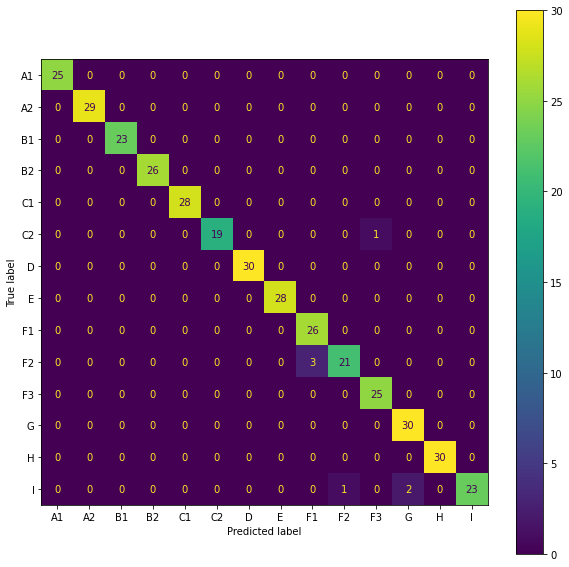

              precision    recall  f1-score   support

          A1       1.00      1.00      1.00        25
          A2       1.00      1.00      1.00        29
          B1       1.00      1.00      1.00        23
          B2       1.00      1.00      1.00        26
          C1       1.00      1.00      1.00        28
          C2       1.00      0.95      0.97        20
           D       1.00      1.00      1.00        30
           E       1.00      1.00      1.00        28
          F1       0.90      1.00      0.95        26
          F2       0.95      0.88      0.91        24
          F3       0.96      1.00      0.98        25
           G       0.94      1.00      0.97        30
           H       1.00      1.00      1.00        30
           I       1.00      0.88      0.94        26

    accuracy                           0.98       370
   macro avg       0.98      0.98      0.98       370
weighted avg       0.98      0.98      0.98       370



In [49]:
y_pred = cross_val_predict(clf.best_estimator_, attri, target, n_jobs=-1,cv=8)
conf_mat = confusion_matrix(target, y_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=conf_mat,
    display_labels=clf.classes_
)
fig, ax = plt.subplots(figsize=(10,10))
plt.grid(False)
disp.plot(ax=ax)
plt.show()
print(classification_report(target, y_pred))

In [50]:
from sklearn.metrics import precision_recall_fscore_support
res = []
for l in clf.classes_:
    prec,recall,_,_ = precision_recall_fscore_support(np.array(target)==l,
                                                      np.array(y_pred)==l,
                                                      pos_label=True,average=None)
    res.append([l,recall[0],recall[1]])
    
sen_spe_df = pd.DataFrame(res,columns = ['class','specificity','sensitivity'])
sen_spe_df

,class,specificity,sensitivity
0,A1,1.000000,1.000000
1,A2,1.000000,1.000000
2,B1,1.000000,1.000000
3,B2,1.000000,1.000000
4,C1,1.000000,1.000000
5,C2,1.000000,0.950000
6,D,1.000000,1.000000
7,E,1.000000,1.000000
8,F1,0.991279,1.000000
9,F2,0.997110,0.875000


In [52]:
# specificity = tn/(tn+fp)
sen_spe_df['specificity'].mean()

0.9985434280493731

In [51]:
# sensitivity TP/(TP+FN)
sen_spe_df['sensitivity'].mean()

0.9792582417582417